## summary
This is a summmary notebook for my meeting on September 30, 2025. This will briefly summarize the results from the Southern Barents Sea with concrete findings and propose concrete research questions based on the literature.

Summary figure will include:
- Figure 1: inflow properties with a) time series of T and S for the two years to highlight winter differences at BIT
- Figure 2: surface forcing with a) seasonal cycle of surface heat flux and b) maps of 2016-2007
- Figure 3: vertical profiles (to explain convection)
- Figure 4: BSW formation, volume of BSW is greater, heat stays at depth when traveling to N Barents

In [2]:
# import the packages and maps
# import packages and functions
# define figure path to save lots of figures - we choose relevant ones to talk about
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import gzip

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd  # For rolling mean
from scipy.ndimage import binary_dilation
from matplotlib.lines import Line2D

import h5py
from scipy.io import loadmat
from scipy.io import savemat

sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from get_Jterms import *  # this will also set up the grid should be

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
from matplotlib.colors import ListedColormap as ListedColormap

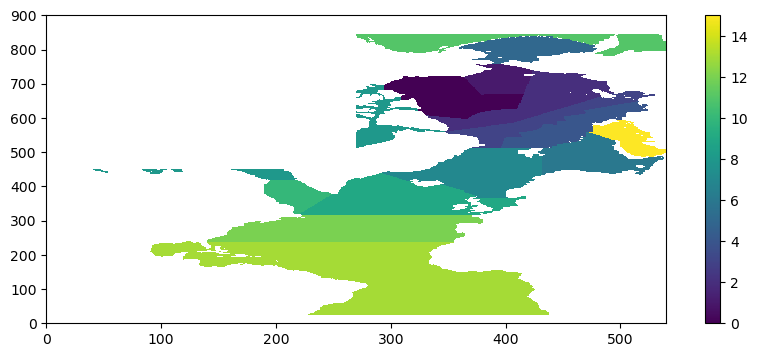

In [4]:
# load the whole Basin mask
# copy over the mask
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# we have to add in until the edge of novaya zemlya
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk2[:487,510:] = 1
mymsk2[:490,532:] = 1
mymsk = aste_tracer2compact(mymsk2,nfx,nfy)[0]

# remember to mask with land so we have the correct item
mymsk = mymsk * hfC[0]
mymsk[mymsk == 0] = np.nan


# extend the Barents Sea up to the gate between NZ--RU
mskBasin[mymsk == 1] = 6

ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()

ind2d = mskBasin.reshape(364500)
ind2d.shape
# iBarentsS2D = np.where(ind2d == 7)[0]

mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

ind2d_wet = ind2d[iwetC2d]
iwet_BarentsS2D = np.where(ind2d_wet == 6)[0]
iwet_mine = iwet_BarentsS2D
imask = np.where(ind2d == -1)[0]
iwet_mymsk = np.where(ind2d_wet == 6)[0]

In [5]:
# define the gateways
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

x_nzru = np.full((5),37)
y_nzru = np.arange(460,465,1)

gates = np.full(mskBasin.shape,np.nan)
gates[y_bso,x_bso] = 1
gates[y_sfj,x_sfj] = 2
gates[y_fjnz,x_fjnz] = 3
gates[y_nzru,x_nzru] = 4

In [6]:
barton_mask = np.load("poly_mask.npy")

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

In [7]:
barton_mask[barton_mask == 0] = np.nan

### Figure 1: timeseries of TFLUX and SFLUX + oceSPflx

In [8]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
# allyears = np.arange(2003,2018,1)

In [11]:
allyears = np.array([2007,2016])

times = {}
times["2007"] = np.arange(1,13,1)   # write all the months for this example 5-year period
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

times = {}
times["2016"] = np.arange(1,13,1)   # write all the months for this example 5-year period
tsstr2,datetimes2 = get_tsteps(times,fnames,dt_aste,startyr,1,1)

In [12]:
# plot the differences between surface temperature: TFLUX oceQsw SItflux oceQnet WTHMASS

def get_recs(dirIn, file_name, ts0, varnames):
    meta = parsemeta(f"{dirIn}{file_name}.{ts0}.meta")
    fldlist = np.array(meta["fldList"]).astype(str)   # robust if bytes
    return [int(np.where(fldlist == v)[0][0]) for v in varnames]

def read_fields(dirIn, file_name, t2, recs, nx, ny):
    outs = []
    for r in recs:
        fld, its, meta = rdmds(os.path.join(dirIn, file_name), t2, returnmeta=True, rec=int(r))
        outs.append(fld.reshape(ny, nx))
    return outs

def collect_year_with_tsstr(dirIn, tsstr, nx, ny):
    nt = len(tsstr)

    set1_name, set1_vars = "budg2d_zflux_set1", ["TFLUX","oceQsw","SItflux"]
    set2_name, set2_vars = "budg2d_zflux_set2", ["oceQnet","WTHMASS","SIaaflux","TRELAX"]

    set1_recs = get_recs(dirIn, set1_name, tsstr[0], set1_vars)
    set2_recs = get_recs(dirIn, set2_name, tsstr[0], set2_vars)

    out = {
        "TFLUX":   np.empty((nt, ny, nx)),
        "oceQsw":  np.empty((nt, ny, nx)),
        "SItflux": np.empty((nt, ny, nx)),
        "oceQnet": np.empty((nt, ny, nx)),
        "WTHMASS": np.empty((nt, ny, nx)),
        "SIaaflux":np.empty((nt, ny, nx)),
        "TRELAX":  np.empty((nt, ny, nx)),
    }

    for i in range(nt):
        t2 = int(tsstr[i])  # <-- per your note

        TFLUX, oceQsw, SItflux = read_fields(dirIn, set1_name, t2, set1_recs, nx, ny)
        out["TFLUX"][i]    = TFLUX
        out["oceQsw"][i]   = oceQsw
        out["SItflux"][i]  = SItflux

        oceQnet, WTHMASS, SIaaflux, TRELAX = read_fields(dirIn, set2_name, t2, set2_recs, nx, ny)
        out["oceQnet"][i]  = oceQnet
        out["WTHMASS"][i]  = WTHMASS
        out["SIaaflux"][i] = SIaaflux
        out["TRELAX"][i]   = TRELAX

    return out

# ----- run for 2007 + 2016 -----
data_2007 = collect_year_with_tsstr(dirIn, tsstr,  nx, ny)   # t2 = int(tsstr[i])
data_2016 = collect_year_with_tsstr(dirIn, tsstr2, nx, ny)   # t2 = int(tsstr2[i])

np.savez("zflux_2007.npz", **data_2007)
np.savez("zflux_2016.npz", **data_2016)

# ----- load later -----
d07 = np.load("zflux_2007.npz")
d16 = np.load("zflux_2016.npz")
# e.g., TFLUX_2016 = d16["TFLUX"]


In [16]:
mymsk = barton_mask

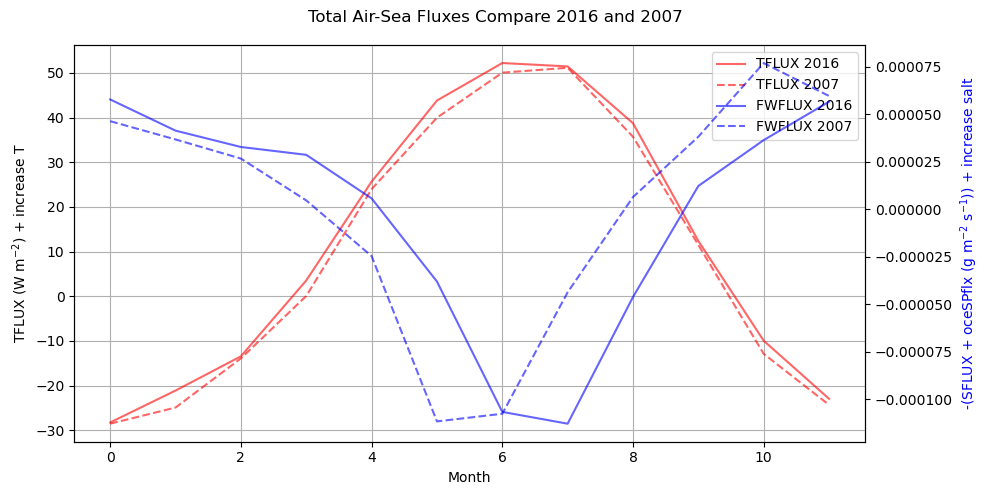

In [43]:
# ---- load saved yearly fields ----
d07 = np.load("zflux_2007.npz")
d16 = np.load("zflux_2016.npz")

# ----- load later -----
s07 = np.load("sflux_2007.npz")   # keys: oceSPflx, SFLUX, oceSflux, WSLTMASS, SRELAX
s16 = np.load("sflux_2016.npz")

# mymsk: boolean or {0,1} mask of shape (ny, nx); True/1 where you want to average
# e.g., mymsk = np.load("mymsk.npy")  # ensure dtype=bool or {0,1}

def masked_time_mean(field_tyx, mask_bool):
    """
    field_tyx: (t, ny, nx)
    mask_bool: (ny, nx) True inside region
    returns (t,) masked spatial mean, ignoring NaNs outside mask
    """
    # ensure boolean
    m = mask_bool.astype(bool)
    # broadcast mask over time and set outside to NaN
    masked = np.where(m[None, :, :], field_tyx, np.nan)
    # spatial mean over ny,nx for each time
    return np.nanmean(masked, axis=(1,2))

# ---- pull fields ----
TFLUX07 = d07["TFLUX"]         # (t, ny, nx), W/m^2
TFLUX16 = d16["TFLUX"]

# Make sure these exist in your npz; if not, add them to collect_year_with_tsstr and re-save
SFLUX07    = s07["SFLUX"]      # (t, ny, nx), g/m^2/s (net surface salt/freshwater flux—your sign convention)
oceSPflx07 = s07["oceSPflx"]   # (t, ny, nx), g/m^2/s
SFLUX16    = s16["SFLUX"]
oceSPflx16 = s16["oceSPflx"]

# ---- compute masked spatial means ----
TFLUX07_mean = masked_time_mean(TFLUX07, mymsk)
TFLUX16_mean = masked_time_mean(TFLUX16, mymsk)

FWFLUX07_mean = masked_time_mean(SFLUX07 + oceSPflx07, mymsk)  # g/m^2/s
FWFLUX16_mean = masked_time_mean(SFLUX16 + oceSPflx16, mymsk)

# ---- time vector ----
nt = TFLUX07_mean.shape[0]
t = np.arange(nt)  # replace with actual datetime index if you have it

fig, ax1 = plt.subplots(figsize=(10, 5))

# --- left y-axis: TFLUX ---
lns1 = ax1.plot(t, TFLUX16_mean, 'r-',  label='TFLUX 2016',alpha=0.6)
lns2 = ax1.plot(t, TFLUX07_mean, 'r--', label='TFLUX 2007',alpha=0.6)
ax1.set_ylabel(r"TFLUX (W m$^{-2}$) + increase T", color='k')

# --- right y-axis: Freshwater flux ---
ax2 = ax1.twinx()
lns3 = ax2.plot(t, -FWFLUX16_mean, 'b-',  label='FWFLUX 2016',alpha=0.6)
lns4 = ax2.plot(t, -FWFLUX07_mean[1:], 'b--', label='FWFLUX 2007',alpha=0.6)
ax2.set_ylabel(r"-(SFLUX + oceSPflx (g m$^{-2}$ s$^{-1}$)) + increase salt", color='b')

# --- combine legends ---
lns = lns1 + lns2 + lns3 + lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right')

ax1.set_xlabel("Month")   # or timestep index
ax1.grid()
# ax2.grid()

plt.suptitle("Total Air-Sea Fluxes Compare 2016 and 2007")
plt.tight_layout()
plt.show()



## Let's also plot the EXF fields for these two years so we can see

In [47]:
## We're looking for EXFtaux and EXFtauy in dirIn/exf_zflux_set1

def get_recs(dirIn, file_name, ts0, varnames):
    """Return a dict var->rec_index or None if not found."""
    meta = parsemeta(f"{dirIn}{file_name}.{ts0}.meta")
    fldlist = np.array(meta["fldList"]).astype(str)
    recs = {}
    for v in varnames:
        idx = np.where(fldlist == v)[0]
        recs[v] = int(idx[0]) if idx.size > 0 else None
    return recs

def read_one(dirIn, file_name, t2, rec, nx, ny):
    """Read one record and reshape to (ny,nx). If rec is None, return NaNs."""
    if rec is None:
        return np.full((ny, nx), np.nan, dtype=float)
    fld, its, meta = rdmds(os.path.join(dirIn, file_name), t2, returnmeta=True, rec=int(rec))
    return fld.reshape(ny, nx)

def collect_year_tau(dirIn, tsstr, nx, ny):
    """
    For a given list of timestep strings, read wind stress components:
      exf_zflux_set1: EXFtaux, EXFtauy
    Return dict of arrays stacked as (nt, ny, nx).
    """
    nt = len(tsstr)

    set_name, set_vars = "exf_zflux_set1", ["EXFtaux", "EXFtauy"]

    # parse record indices once using the first timestep
    set_recs = get_recs(dirIn, set_name, tsstr[0], set_vars)

    # preallocate
    out = {v: np.empty((nt, ny, nx), dtype=float) for v in set_vars}

    # loop over timesteps
    for i, ts in enumerate(tsstr):
        t2 = int(ts)

        out["EXFtaux"][i] = read_one(dirIn, set_name, t2, set_recs["EXFtaux"], nx, ny)
        out["EXFtauy"][i] = read_one(dirIn, set_name, t2, set_recs["EXFtauy"], nx, ny)

    return out

# ----- run for 2007 + 2016 -----
tau_2007 = collect_year_tau(dirIn, tsstr,  nx, ny)
tau_2016 = collect_year_tau(dirIn, tsstr2, nx, ny)

np.savez("tau_2007.npz", **tau_2007)
np.savez("tau_2016.npz", **tau_2016)

# ----- load later -----
t07 = np.load("tau_2007.npz")   # keys: EXFtaux, EXFtauy
t16 = np.load("tau_2016.npz")


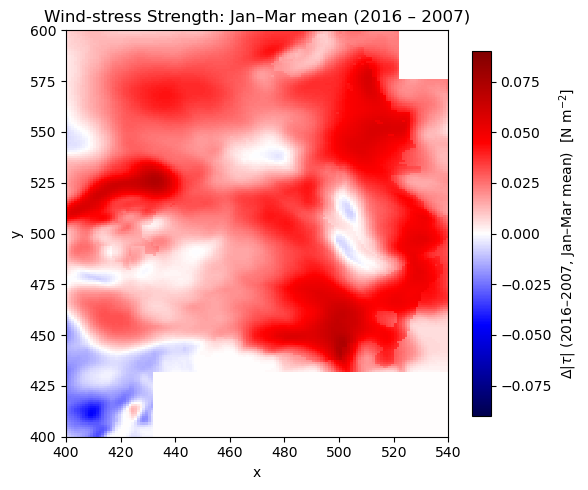

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Load (t, ny, nx)
t07 = np.load("tau_2007.npz")   # EXFtaux, EXFtauy
t16 = np.load("tau_2016.npz")

tx07, ty07 = t07["EXFtaux"], t07["EXFtauy"]
tx16, ty16 = t16["EXFtaux"], t16["EXFtauy"]

# --- Jan–Mar = indices [0,1,2] ---
idx_jfm = [0, 1, 2]

mag07_jfm = np.hypot(tx07[idx_jfm], ty07[idx_jfm]).mean(axis=0)  # (ny, nx)
mag16_jfm = np.hypot(tx16[idx_jfm], ty16[idx_jfm]).mean(axis=0)

# --- Difference (2016 – 2007), masked ---
mask = mymsk.astype(bool)
diff = np.where(mask, mag16_jfm - mag07_jfm, np.nan)  # (ny, nx)

# --- Prepare for ASTE tracer plotting ---
vals_for_plot = get_aste_tracer(diff, nfx, nfy)[0]

# Symmetric color range
v = np.nanpercentile(np.abs(diff), 99)

fig, ax = plt.subplots(figsize=(6,5))
try:
    X, Y, V = vals_for_plot
    im = ax.pcolormesh(X, Y, V, cmap="seismic", vmin=-v, vmax=v, shading="auto")
except (TypeError, ValueError):
    V = vals_for_plot
    im = ax.pcolormesh(V, cmap="seismic", vmin=-v, vmax=v, shading="auto")

cbar = fig.colorbar(im, ax=ax, shrink=0.9)
cbar.set_label(r"$\Delta|\tau|$ (2016–2007, Jan–Mar mean)  [N m$^{-2}$]")

ax.set_title("Wind-stress Strength: Jan–Mar mean (2016 – 2007)")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

plt.tight_layout()
plt.show()
